## Imports

In [1]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

import math

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
import h5py as h5
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    import gwpy
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    import gwpy
    from gwpy.timeseries import TimeSeries

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
device

'cuda'

## Load Data

**Load full dataset resampled to 500Hz and normalised** (according to def standardise(ts))

In [5]:
def get_glitch(df):
    selected_indices=list(range(1,len(df),3))
    return df.iloc[selected_indices]

In [6]:
df=get_glitch(pd.read_pickle('/kaggle/input/img-pix2pix-gws-scattered-light/Image_dataset_1000'))

In [7]:
df=pd.concat([df, get_glitch(pd.read_pickle('/kaggle/input/img-pix2pix-gws-scattered-light/Image_dataset_1000_2000'))])
df=pd.concat([df, get_glitch(pd.read_pickle('/kaggle/input/img-pix2pix-gws-scattered-light/Image_dataset_2000_3000'))])
df=pd.concat([df, get_glitch(pd.read_pickle('/kaggle/input/img-pix2pix-gws-scattered-light/Image_dataset_3000_4000'))])
df=pd.concat([df, get_glitch(pd.read_pickle('/kaggle/input/img-pix2pix-gws-scattered-light/Image_dataset_4000_5000'))])
#df=pd.concat([df, pd.read_pickle('/kaggle/input/img-pix2pix-gws-scattered-light/Image_dataset_2000_3000')])
#df=pd.concat([df, pd.read_pickle('/kaggle/input/img-pix2pix-gws-scattered-light/Image_dataset_3000_4000')])

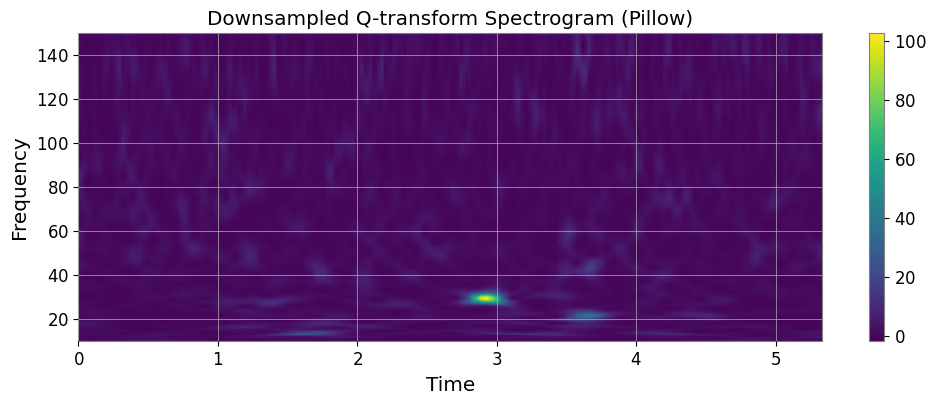

In [8]:
qplot_test=df.iloc[0,0]
plt.figure(figsize=(12, 4))
plt.imshow(qplot_test, aspect='auto', extent=[0, 16/3, 10, 150])
plt.title('Downsampled Q-transform Spectrogram (Pillow)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


In [9]:
df = df.applymap(lambda x: torch.tensor(x))

/tmp/ipykernel_42/1342047437.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: torch.tensor(x))


## Split Data

In [10]:
df_aux_all_2d = pd.DataFrame(df[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR','V1:LSC_PR_CORR']])#,'V1:LSC_DARM_ERR'
df_main_all_2d = pd.DataFrame(df['V1:Hrec_hoft_16384Hz'])

In [11]:
del df

In [12]:
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(df_aux_all_2d, df_main_all_2d, test_size=0.3, random_state=42)

#signal_data_train=torch.stack([torch.stack([df['V1:Hrec_hoft_16384Hz'][i]]) for i in range(n_train)])
#aux_data_train=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1],df_aux.loc[i][2],df_aux.loc[i][3],df_aux.loc[i][4]]) for i in range(n_train)])
signal_data_train_small_2d = torch.stack([torch.stack([y_train_2d['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(100)]) #for i in range(y_train.shape[0])
aux_data_train_small_2d = torch.stack([torch.stack([X_train_2d.iloc[i][0], X_train_2d.iloc[i][1], X_train_2d.iloc[i][2]]) for i in range(100)]) #for i in range(X_train.shape[0])

signal_data_train_2d = torch.stack([torch.stack([y_train_2d['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(y_train_2d.shape[0])]) #
aux_data_train_2d = torch.stack([torch.stack([X_train_2d.iloc[i][0], X_train_2d.iloc[i][1], X_train_2d.iloc[i][2]]) for i in range(X_train_2d.shape[0])]) #



train_data_2d=torch.cat([signal_data_train_2d,aux_data_train_2d],dim=1) 
train_data_small_2d=torch.cat([signal_data_train_small_2d,aux_data_train_small_2d],dim=1) 

print(signal_data_train_2d.shape)
print(aux_data_train_2d.shape)

# Extract the signal and auxiliary data for testing
signal_data_test_small_2d = torch.stack([torch.stack([y_test_2d['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(100)]) #for i in range(y_test.shape[0])
aux_data_test_small_2d = torch.stack([torch.stack([X_test_2d.iloc[i][0], X_test_2d.iloc[i][1], X_test_2d.iloc[i][2]]) for i in range(100) ]) #for i in range(X_test.shape[0])

signal_data_test_2d = torch.stack([torch.stack([y_test_2d['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(y_test_2d.shape[0])]) #
aux_data_test_2d = torch.stack([torch.stack([X_test_2d.iloc[i][0], X_test_2d.iloc[i][1], X_test_2d.iloc[i][2]]) for i in range(X_test_2d.shape[0]) ]) #

test_data_2d = torch.cat([signal_data_test_2d, aux_data_test_2d], dim=1) 
test_data_small_2d = torch.cat([signal_data_test_small_2d, aux_data_test_small_2d], dim=1) 

print(signal_data_test_2d.shape)
print(aux_data_test_2d.shape)


/tmp/ipykernel_42/1578758213.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aux_data_train_small_2d = torch.stack([torch.stack([X_train_2d.iloc[i][0], X_train_2d.iloc[i][1], X_train_2d.iloc[i][2]]) for i in range(100)]) #for i in range(X_train.shape[0])
/tmp/ipykernel_42/1578758213.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aux_data_train_2d = torch.stack([torch.stack([X_train_2d.iloc[i][0], X_train_2d.iloc[i][1], X_train_2d.iloc[i][2]]) for i in range(X_train_2d.shape[0])]) #


torch.Size([3500, 1, 256, 256])
torch.Size([3500, 3, 256, 256])


/tmp/ipykernel_42/1578758213.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aux_data_test_small_2d = torch.stack([torch.stack([X_test_2d.iloc[i][0], X_test_2d.iloc[i][1], X_test_2d.iloc[i][2]]) for i in range(100) ]) #for i in range(X_test.shape[0])
/tmp/ipykernel_42/1578758213.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aux_data_test_2d = torch.stack([torch.stack([X_test_2d.iloc[i][0], X_test_2d.iloc[i][1], X_test_2d.iloc[i][2]]) for i in range(X_test_2d.shape[0]) ]) #


torch.Size([1500, 1, 256, 256])
torch.Size([1500, 3, 256, 256])


In [13]:
batch_size = 16

In [14]:
def normalize_(data,chan=4):
    #data -= data.min((-1,-2), keepdim=True)[0]
    data /=data.view(data.shape[0],chan,-1).max((-1), keepdim=True)[0].view(data.shape[0],chan,1,1)
    return data

In [15]:
train_data_2d=normalize_(train_data_2d)

In [16]:
test_data_2d=normalize_(test_data_2d)


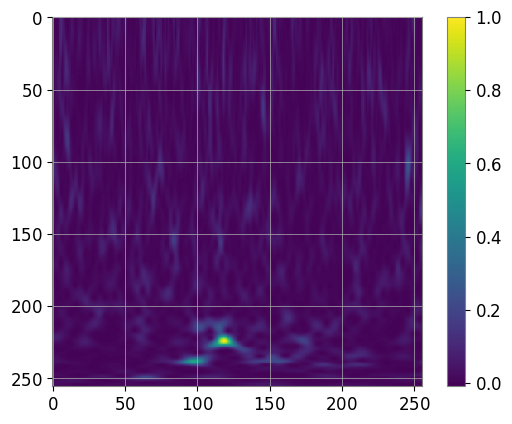

In [17]:
plt.imshow(test_data_2d[6,0])
plt.colorbar()

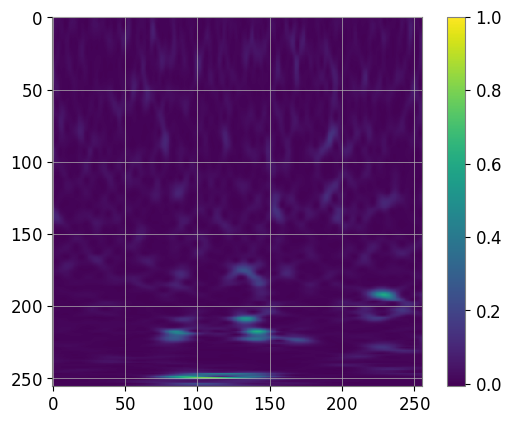

In [18]:
plt.imshow(train_data_2d[6,3])
plt.colorbar()

In [19]:
dataloader = DataLoader(
    train_data_2d,
    batch_size=batch_size,
    shuffle=True,
)


test_dataloader = DataLoader(
    test_data_2d,
    batch_size=batch_size,
    shuffle=False,
)

# Model

In [20]:
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function 

## Generator

#### If you want to only use the Decoder, just run the next 3 cells and skip directly to the Training part

In [21]:
class RescaledSigmoid(nn.Module):
    def __init__(self,a=80.0):
        super().__init__()
        self.scaling=torch.nn.Parameter(torch.tensor(a))
        self.sigmoid = torch.nn.Sigmoid()
        
    def __call__(self,x):
        return self.scaling *self.sigmoid(x)

In [22]:
class Decoder(nn.Module):
    def __init__(self, in_channels, kernel_size=7,a=80.0):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(32, 64,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(64, 64,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv2d(64, 1, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        
        
        self.activation =torch.nn.Sigmoid()

        self.scaled=RescaledSigmoid(a)
    def _forward_features(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        x= self.activation(x)
        return x

    def forward(self, x):
        return self._forward_features(x)


In [23]:
def make_conv_net(hidden_sizes, kernel_size, in_channels, out_channels,bn,drop,activation='leaky'):
    '''
    Convolutionaal Neural Netowrk
    hiddens_sizes=[N_filters for hidden layer 1, .... ,N_filters for hidden layer n]
    num hidden layers = len(hidden_sizes)
    kernel_size= kernel size for layer i (included output layer)
    bn = add batch normalization after layer i if bn[i]==True
    drop= add dropout with p=drop[i] if drop[i]!= None/False
    dilation = dilation[i] dilation for layer i (included output)
    activatio: choose one of leaky (leakyrelu), tanh, relu, gelu
    '''
    sizes = [in_channels] + hidden_sizes + [out_channels]
    net = []
    for i in range(len(sizes) - 1):
        conv = torch.nn.Conv2d(sizes[i], sizes[i+1], kernel_size[i], padding=kernel_size[i]//2, stride=1, padding_mode='zeros',dilation=1)
        net.append(conv)
        if i != len(sizes) - 2:
            if bn[i]:
                net.append(nn.BatchNorm2d(sizes[i+1]))
            if drop[i]:
                net.append(nn.Dropout(p=drop[i]))
            if activation=="leaky":
                net.append(torch.nn.LeakyReLU(0.2))
            elif activation=="tanh":
                net.append(torch.nn.Tanh())
            elif activation=='relu':
                net.append(torch.nn.ReLU())
            elif activation == 'gelu':
                net.append(nn.GELU())
            
    return torch.nn.Sequential(*net)

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block, output_shape):
        super(GeneratorResNet, self).__init__()

        channels = input_shape
        target_channels = output_shape
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(target_channels),
                  nn.Conv2d(out_features,  target_channels, 3),
                  nn.Sigmoid() #tune this activation
                 ]

        # Unpacking
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Discriminator

In [25]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Training

In [26]:
# Metric function: IOU

def calculate_iou_2d(generated, target, threshold):
    """
    Calculate Intersection over Union (IoU) in the 2D plane at the specified intensity threshold.

    Parameters:
    - generated: List of time series representing the generated spectrograms
    - target: List of time series representing the target spectrograms
    - threshold: Intensity threshold for determining the binary masks

    Returns:
    - IoU: Intersection over Union
    """
    # Extract spectrogram values from time series
    # print(generated[0][0])
    # print(generated[0][0].shape)
    # print(type(generated[0][0]))
    
    
    spectrograms_gen = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in generated]
    spectrograms_real = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in target]

    # Create binary masks based on the intensity threshold
    mask1 = [spectrogram >= threshold for spectrogram in spectrograms_gen]
    mask2 = [spectrogram >= threshold for spectrogram in spectrograms_real]

    # Calculate the intersection and union of the binary masks
    intersection = [np.logical_and(m1, m2) for m1, m2 in zip(mask1, mask2)]
    union = [np.logical_or(m1, m2) for m1, m2 in zip(mask1, mask2)]

    # Calculate Intersection over Union (IoU)
    iou_list = np.array([np.sum(inter) / np.sum(uni) for inter, uni in zip(intersection, union)])

    iou = iou_list.mean()
    return iou


In [27]:
#more sophisticated loss function

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

# utils function to generate data using the decoder    
def generate_data(generator,batch):
    #batch= transform(batch)
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    #print(input.float())
    with torch.no_grad():
        generated = generator(input.float())
        generated=normalize_(generated,1)
    return generated

In [28]:
def train_decoder(num_epochs,generator,criterion,optimizer,dataloader,val_loader,accuracy,checkpoint_path, save_best=False):
    # num_epochs: (int) number of epochs for training
    # generator: (NN.Module) NN model to train
    # criterion: (torch.optim) optimiser to use in training
    # dataloader: (DataLoader) training data
    # val_loader: (Dataloader) validation data
    # accuracy: (function) metric to measure performance of the model (Note not to be confused with loss)
    # checkpoint_path: (str) full path (including filename in the form filename_{}.pkl so to insert num_epoch) to save checkpoints at
    # save_best: (bool) if you want to save best performing model
    
    
    #uncomment all lines relative to accuracy if you want to measure IOU between generated and real spectrograms.
    #Note that it significantly slows down the whole process
    
    loss_plot =[]
    val_loss_plot =[]
    acc_plot=[]
    val_acc_plot=[]
    best_val_loss=5000000
    for epoch in tqdm(range(1,num_epochs+1)):
        epoch_loss =[]
        epoch_acc=[]
        for i, batch in enumerate(dataloader):
            #batch= transform(batch)
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            
            optimizer.zero_grad()
            generated = generator(input.float())
            #generated=normalize_(generated,1)
            loss=criterion(generated,target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.detach().cpu().numpy())
            #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
            #epoch_acc.append(acc)
        val_loss =[]
        val_acc=[]
        for batch in(val_loader):
            #batch= transform(batch)
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            with torch.no_grad():
                generated = generator(input.float())
                #generated=normalize_(generated,1)
                loss=criterion(generated,target)
                val_loss.append(loss.detach().cpu().numpy())
                #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
                #val_acc.append(acc)
        loss_plot.append(np.mean(epoch_loss))
        val_loss_plot.append(np.mean(val_loss))
        acc_plot.append(np.mean(epoch_acc))
        val_acc_plot.append(np.mean(val_acc))
        #print('epoch: {} loss: {} val loss: {} accuracy: {} val accuracy: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1],acc_plot[-1],val_acc_plot[-1]))
        print('epoch: {} loss: {} val loss: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1]))
        
        # Save checkpoint every 100 epochs
        if (epoch+1) % 100 == 0:
            #uncomment the following if you want to save checkpoint every 100 epochs regardless of the performance of the model
            # checkpoint = {
            #     'epoch': epoch,
            #     'model_state_dict': generator.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'loss': loss_plot[-1],
            #     'val_loss': val_loss_plot[-1],
            # }
            
            # checkpoint_filename = checkpoint_path.format(epoch)
            # torch.save(checkpoint, checkpoint_filename)
            
            if save_best and val_loss_plot[-1] < best_val_loss: # instead of val_loss and best_val loss we should use accuracy!!!
                #create checkpoint
                checkpoint = {
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_plot[-1],
                'val_loss': val_loss_plot[-1],
                }
                
                #save checkpoint only if it is better than the previous ones
                checkpoint_filename = checkpoint_path.format(epoch)
                torch.save(checkpoint, checkpoint_filename)
                
                #update best model
                best_val_loss = val_loss_plot[-1]
                best_checkpoint_filename = checkpoint_path.format('best')
                torch.save(checkpoint, best_checkpoint_filename)
        
        
    return loss_plot, val_loss_plot,acc_plot, val_acc_plot #,acc_plot, val_acc_plot,

In [93]:
def train_gan(n_epochs,generator,discriminator, discriminator_loss,generator_loss, G_optimizer, D_optimizer, dataloader,val_loader,freq=5):
    G_loss_plot =[]
    D_loss_plot =[]
    D_val_plot =[]
    G_val_plot=[]
    for epoch in tqdm(range(1,n_epochs+1)):
        D_loss_list =[]
        G_loss_list =[]
        for i, batch in enumerate(dataloader):
            target = batch[:,0].unsqueeze(1).to(device).float()
            input = batch[:,1:].to(device).float()
            D_optimizer.zero_grad()

            # ground truth labels real and fake
            real_target = Variable(torch.ones(input.size(0), 1,16,16).to(device))
            fake_target = Variable(torch.zeros(input.size(0), 1,16,16).to(device))

            generated= generator(input)

            #Train disc
            disc_inp_fake = torch.cat((input, generated), 1)

            D_fake = discriminator(disc_inp_fake.detach())
            #print(D_fake.shape)
            D_fake_loss   =  discriminator_loss(D_fake, fake_target)

            disc_inp_real = torch.cat((input, target), 1)

            D_real = discriminator(disc_inp_real)
            D_real_loss = discriminator_loss(D_real,  real_target)
            D_total_loss = (D_real_loss + D_fake_loss) / 2
            # compute gradients and run optimizer step
            D_total_loss.backward()
            D_optimizer.step()
            D_loss_list.append(D_total_loss.detach().cpu().numpy())

            #Train Generator
            G_optimizer.zero_grad()
            fake_gen = torch.cat((input, generated), 1)
            G = discriminator(fake_gen)
            G_loss = generator_loss(generated, target, G, real_target)
            # compute gradients and run optimizer step
            G_loss.backward()
            G_optimizer.step()
            G_loss_list.append(G_loss.detach().cpu().numpy())


        D_loss_plot.append(np.mean(D_loss_list))
        G_loss_plot.append(np.mean(G_loss_list))
        if epoch %freq==0:
            D_val, G_val=eval_model(generator,discriminator,val_loader)
            D_val_plot.append(D_val)
            G_val_plot.append(G_val)
            print('epoch: {} generator loss: {} discriminator loss: {} val generator loss: {} val discriminator loss: {} '.format(epoch,G_loss_plot[-1],D_loss_plot[-1],G_val_plot[-1],D_val_plot[-1]))
    return G_loss_plot, D_loss_plot, G_val_plot, D_val_plot

In [30]:
def eval_model(generator, discriminator,dataloader):
    D_loss_list =[]
    G_loss_list =[]
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            target = batch[:,0].unsqueeze(1).to(device).float()
            input = batch[:,1:].to(device).float()
                
            # ground truth labels real and fake
            real_target = Variable(torch.ones(input.size(0), 1,16,16).to(device))
            fake_target = Variable(torch.zeros(input.size(0), 1,16,16).to(device))

            generated= generator(input)
            disc_inp_fake = torch.cat((input, generated), 1)

            D_fake = discriminator(disc_inp_fake.detach())

            D_fake_loss   =  discriminator_loss(D_fake, fake_target)
            disc_inp_real = torch.cat((input, target), 1)

            D_real = discriminator(disc_inp_real)
            D_real_loss = discriminator_loss(D_real,  real_target)
            D_total_loss = (D_real_loss + D_fake_loss) / 2
            D_loss_list.append(D_total_loss.detach().cpu().numpy())

            fake_gen = torch.cat((input, generated), 1)
            G = discriminator(fake_gen)
            G_loss = generator_loss(generated, target, G, real_target)
            G_loss_list.append(G_loss.detach().cpu().numpy())
    return np.asarray(D_loss_list).mean(), np.asarray(G_loss_list).mean()

In [76]:
adversarial_loss = torch.nn.BCELoss()
l1_loss = torch.nn.L1Loss()

In [77]:
def generator_loss(generated, target, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated, target)
    gen_total_loss = gen_loss + (100 * l1_l) #Tunare parametro scaling
    return gen_total_loss

In [78]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [79]:
#Simple CNN:
generator=GeneratorResNet(3,12,1).to(device) #Decoder(3).to(device) #
init_weights(generator, 'normal', scaling=0.005)
print(generator)

initialize network with normal
GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): Reflect

In [80]:
discriminator=Discriminator((4,256,256)).to(device)
init_weights(discriminator, 'normal', scaling=0.01)
print(discriminator)

initialize network with normal
Discriminator(
  (model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (13): Sigmoid()

In [81]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [82]:
get_n_params(generator)

14909825

In [83]:
get_n_params(discriminator)

2765761

In [84]:
'''#General CNN
hidden_sizes=[64,128,256] #Numero di kernel per hidden layer
kernels=[3,3,3,3] #dimensione dei kernel per ogni layer (compreso l'output)
bn=[True,True,True] #True -> Batch Normalization nel hidden layer corrispondente
drop=[0.3,0.3,0.3] # Dropout with p[i]=drop[i]
generator=make_conv_net(hidden_sizes, kernels, 3, 1,bn,drop).to(device)
init_weights(generator, 'normal', scaling=0.005)
print(generator)'''

"#General CNN\nhidden_sizes=[64,128,256] #Numero di kernel per hidden layer\nkernels=[3,3,3,3] #dimensione dei kernel per ogni layer (compreso l'output)\nbn=[True,True,True] #True -> Batch Normalization nel hidden layer corrispondente\ndrop=[0.3,0.3,0.3] # Dropout with p[i]=drop[i]\ngenerator=make_conv_net(hidden_sizes, kernels, 3, 1,bn,drop).to(device)\ninit_weights(generator, 'normal', scaling=0.005)\nprint(generator)"

In [85]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator,batch)
    break
generated[1,0].shape
#batch=transform(batch)

  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([256, 256])

In [86]:
batch.shape

torch.Size([16, 4, 256, 256])

In [87]:
qplt_g=generated[0,0].detach().cpu().numpy()
qplt_r=batch[0,0].detach().cpu().numpy()

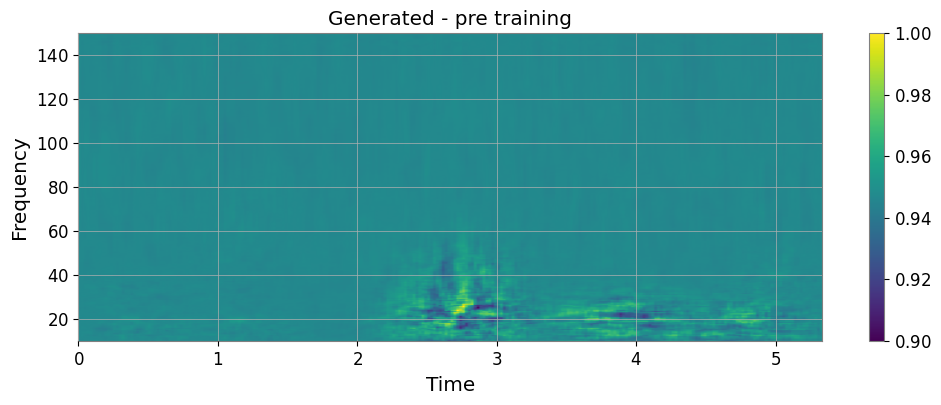

In [88]:
plt.figure(figsize=(12, 4))
plt.imshow(qplt_g, aspect='auto', extent=[0, 16/3, 10, 150])
plt.title('Generated - pre training')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

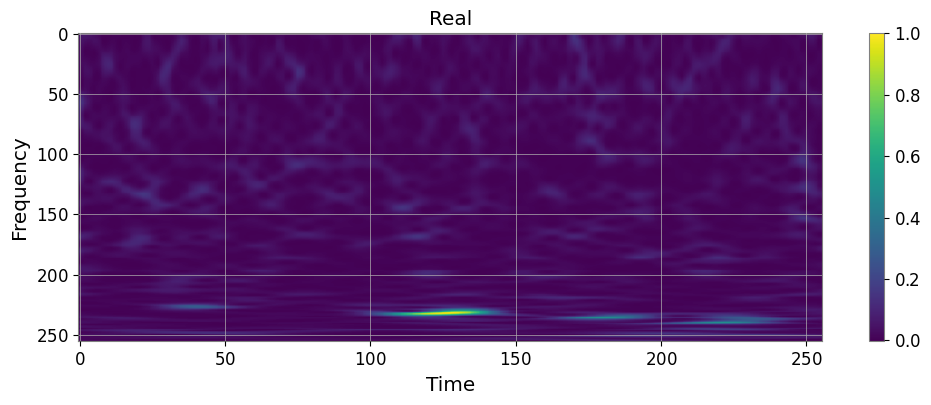

In [89]:
plt.figure(figsize=(12, 4))
plt.imshow(qplt_r, aspect='auto')
plt.title('Real')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


In [94]:
lr=0.00005
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr,betas=[0.5,0.9] )

D_optimizer = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=[0.5,0.9] )

In [97]:
save_checkpoint='/kaggle/working/generator_unet_weights_test.checkpoint_epoch_{}.pth'
n_epochs=25
freq_print =1

In [98]:
G_loss_plot, D_loss_plot, G_val, D_val = train_gan(n_epochs,generator,discriminator, discriminator_loss, generator_loss, G_optimizer, D_optimizer, dataloader,test_dataloader,freq_print)

  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 1 generator loss: 3.885174036026001 discriminator loss: 0.6016696691513062 val generator loss: 3.8901009559631348 val discriminator loss: 0.79021817445755 
epoch: 2 generator loss: 3.9049479961395264 discriminator loss: 0.595321536064148 val generator loss: 4.073263645172119 val discriminator loss: 0.6508256793022156 
epoch: 3 generator loss: 3.9058337211608887 discriminator loss: 0.5962681770324707 val generator loss: 3.636838912963867 val discriminator loss: 0.5861833691596985 
epoch: 4 generator loss: 3.9022037982940674 discriminator loss: 0.5961357951164246 val generator loss: 4.106929302215576 val discriminator loss: 0.5814518332481384 
epoch: 5 generator loss: 3.9244585037231445 discriminator loss: 0.5920343995094299 val generator loss: 3.68806529045105 val discriminator loss: 0.5299282073974609 
epoch: 6 generator loss: 3.945003032684326 discriminator loss: 0.5892972350120544 val generator loss: 3.794212579727173 val discriminator loss: 0.6400853991508484 
epoch: 7 genera

In [99]:
#save model in native PyTorch format (.pth or .pt) 245
torch.save(generator.state_dict(), '/kaggle/working/ResnetMaxpreproc_test.pth')
print('Model saved') 

Model saved


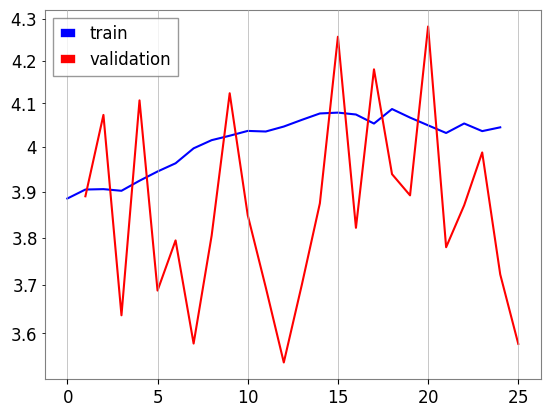

In [100]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(G_loss_plot,color='b',label='train')
plt.plot(np.arange(freq_print,n_epochs+freq_print,freq_print),G_val,color='r',label='validation')
#plt.title('L1 loss vs epoch - 100 Data Standardised and resampled')
plt.legend()
plt.savefig('lcG.pdf')
plt.yscale('log')
plt.show()

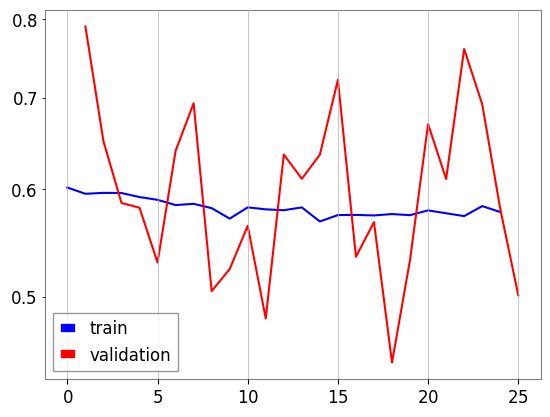

In [101]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(D_loss_plot,color='b',label='train')
plt.plot(np.arange(freq_print,n_epochs+freq_print,freq_print),D_val,color='r',label='validation')
#plt.title('L1 loss vs epoch - 100 Data Standardised and resampled')
plt.legend()
plt.savefig('lcD.pdf')
plt.yscale('log')
plt.show()

In [114]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator,batch)
    break
generated[0,0].shape

  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([256, 256])

In [115]:
qplt_g=generated[0,0].detach().cpu().numpy()
qplt_r=batch[0,0].detach().cpu().numpy()

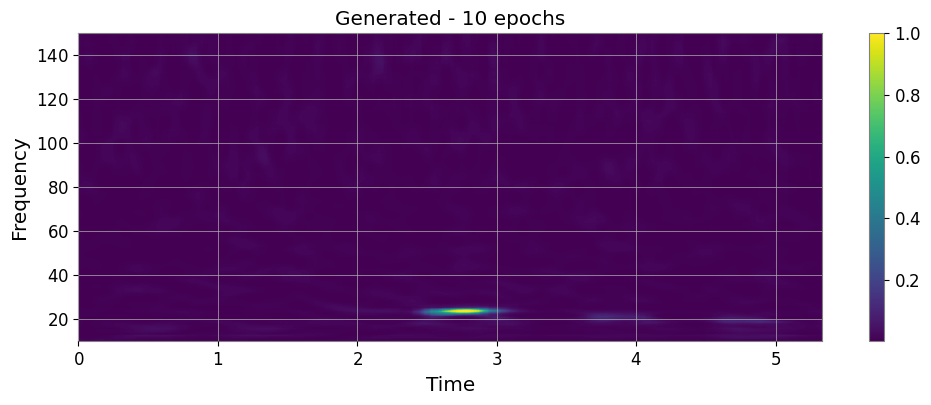

In [116]:
plt.figure(figsize=(12, 4))
plt.imshow(qplt_g, aspect='auto', extent=[0, 16/3, 10, 150])
plt.title('Generated - 10 epochs')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


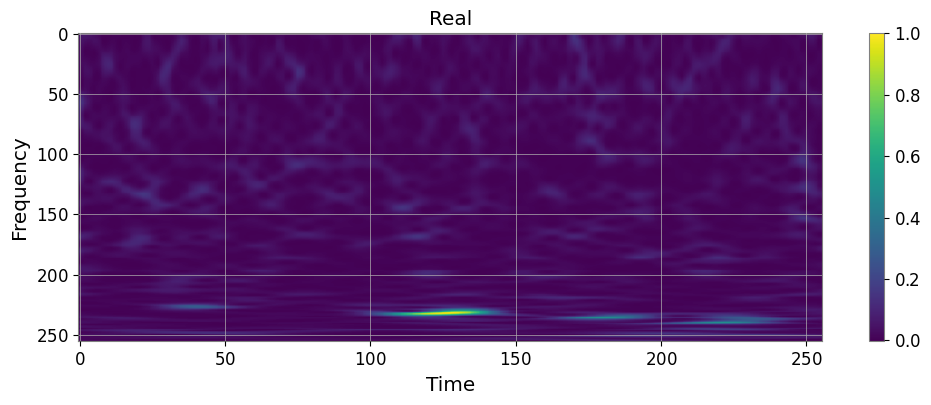

In [117]:
plt.figure(figsize=(12, 4))
plt.imshow(qplt_r, aspect='auto',)
plt.title('Real')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


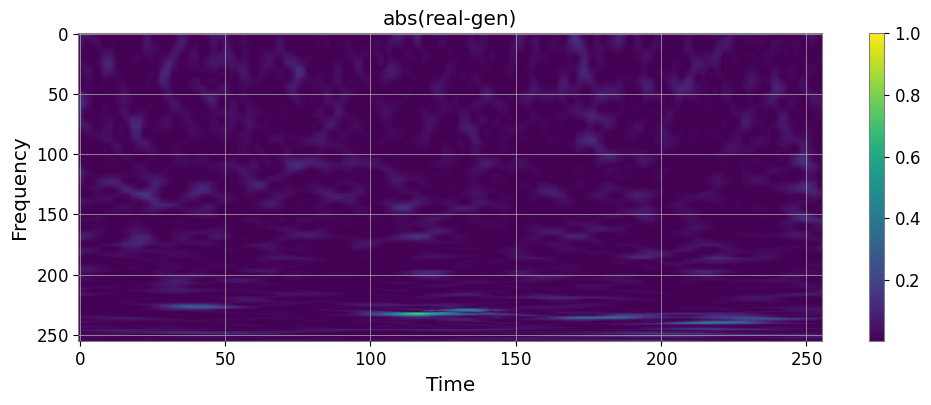

In [118]:
plt.figure(figsize=(12, 4))
plt.imshow(np.abs(qplt_r-qplt_g), aspect='auto',cmap='viridis',vmax=1)
plt.title('abs(real-gen)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


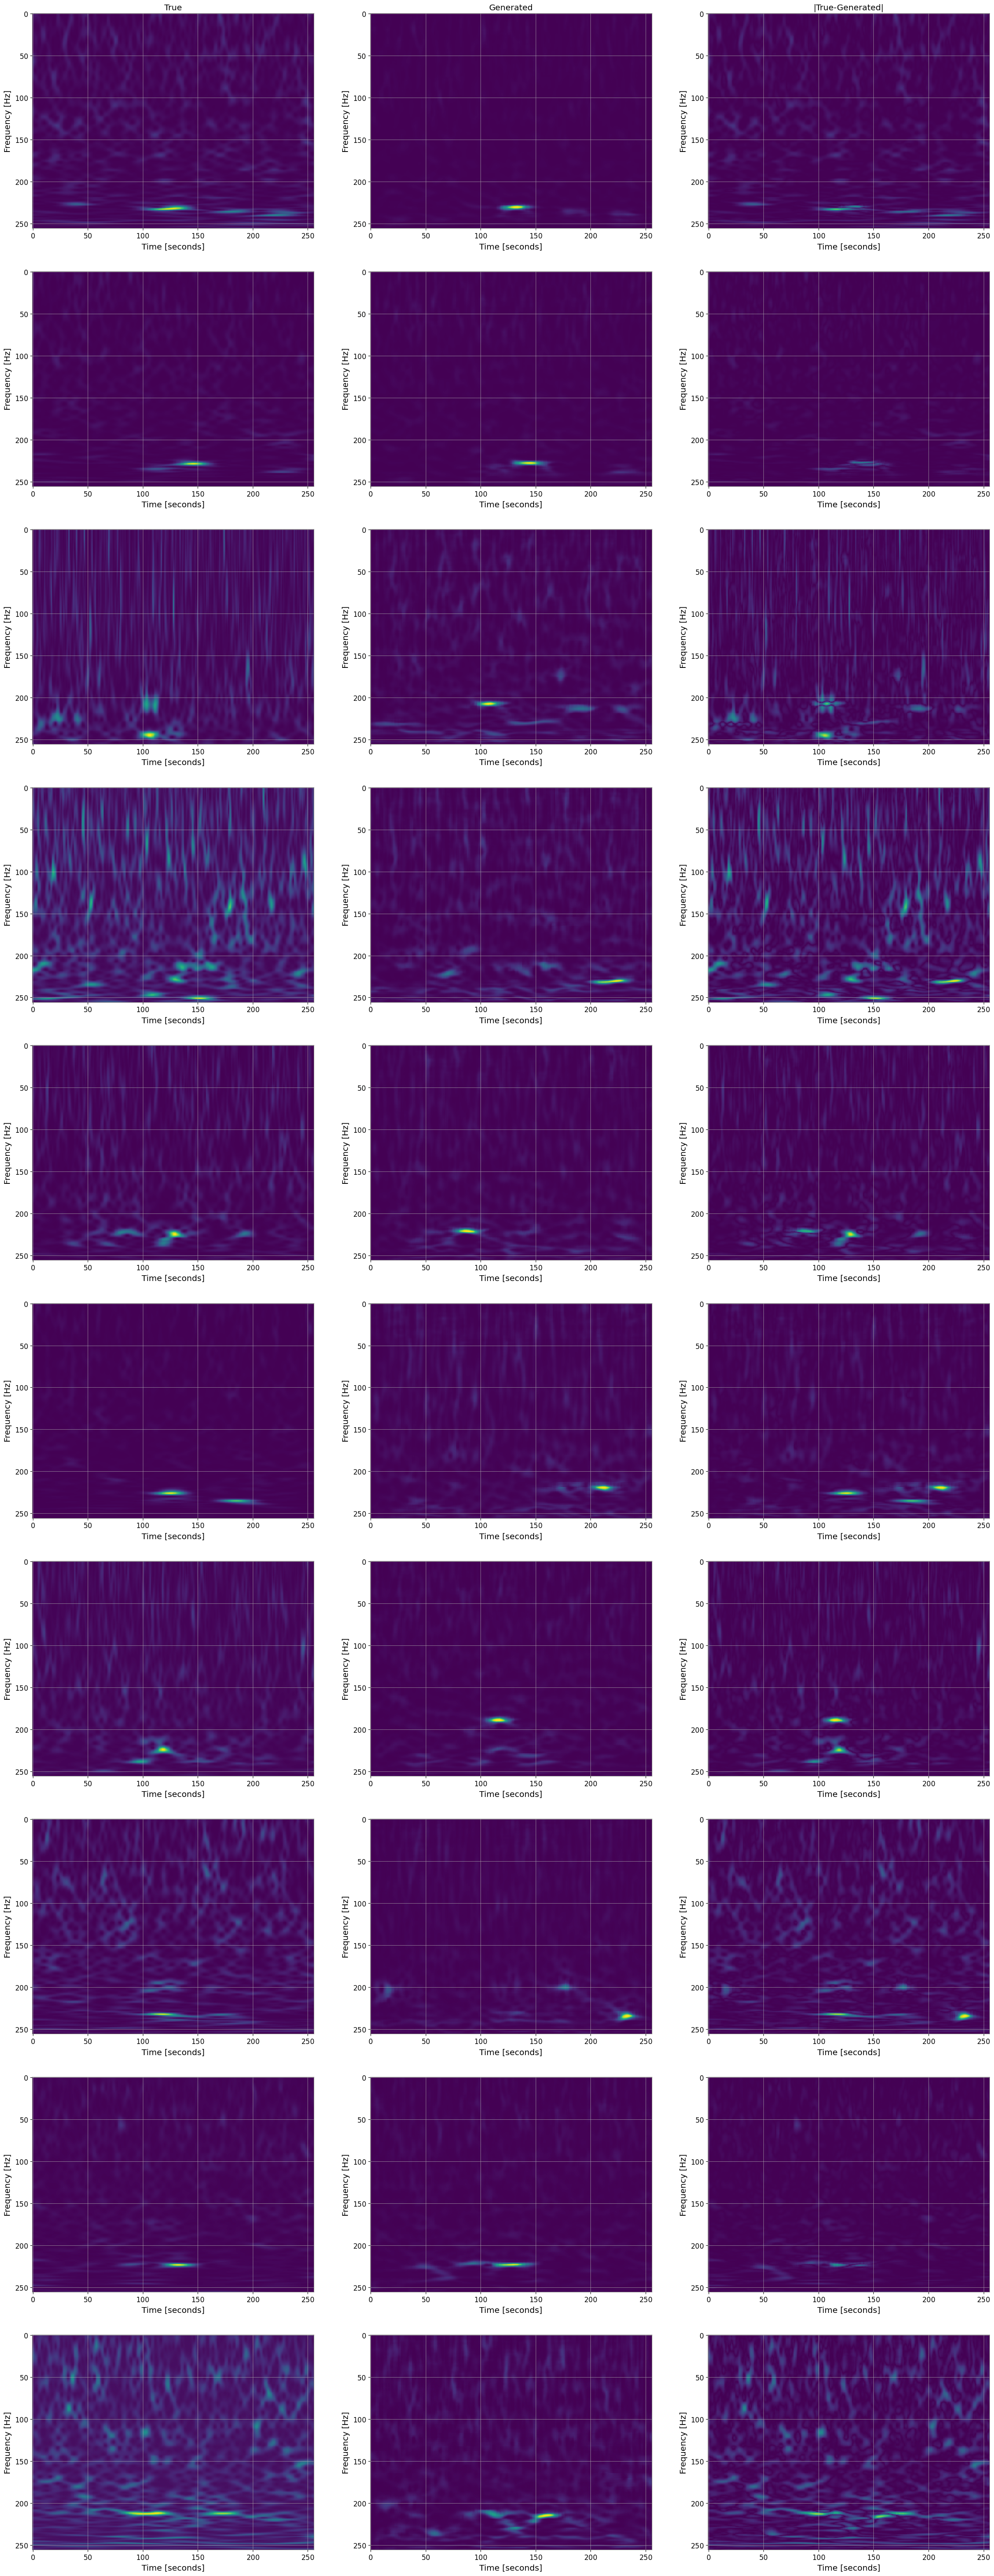

In [119]:
ndata=10
fig, axes = plt.subplots(nrows=ndata, ncols=3, figsize=[30, 8 * ndata])
axes[0,0].set_title('True')
axes[0,1].set_title('Generated')
axes[0,2].set_title('|True-Generated|')
for i in range(ndata):
    qplt_g=generated[i,0].detach().cpu().numpy()
    qplt_r=batch[i,0].detach().cpu().numpy()
    axes[i, 0].imshow(qplt_r, cmap='viridis', aspect='auto',vmax=1  )
    axes[i, 1].imshow(qplt_g, cmap='viridis', aspect='auto',vmax=1  )
    axes[i, 2].imshow(np.abs(qplt_r-qplt_g), cmap='viridis', aspect='auto',vmax=1 )

    #axes[i, 0].set_xscale('seconds')
    #axes[i, 0].set_yscale('log', base=2)
    #axes[i, 0].set_ylim(10, 150)
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [seconds]')

    #axes[i, 1].set_xscale('seconds')
    #axes[i, 1].set_yscale('log', base=2)
    #axes[i, 1].set_ylim(10, 150)
    axes[i, 1].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_xlabel('Time [seconds]')
    
    #axes[i, 2].set_xscale('seconds')
    #axes[i, 2].set_yscale('log', base=2)
    #axes[i, 2].set_ylim(10, 150)
    axes[i, 2].set_ylabel('Frequency [Hz]')
    axes[i, 2].set_xlabel('Time [seconds]')

#plt.colorbar()
    
plt.savefig('Pix2Pix_test1.pdf')


# Plotting The Syntetic Signals

### Load Checkpoint

In [120]:
'''# Define the path to your checkpoint file
checkpoint_path = '/home/jovyan/checkpoints/checkpoint_epoch_best.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state from the checkpoint
generator.load_state_dict(checkpoint['model_state_dict'])'''

"# Define the path to your checkpoint file\ncheckpoint_path = '/home/jovyan/checkpoints/checkpoint_epoch_best.pth'\n\n# Load the checkpoint\ncheckpoint = torch.load(checkpoint_path)\n\n# Load the model state from the checkpoint\ngenerator.load_state_dict(checkpoint['model_state_dict'])"